Calculate Ocean Mixed Layer Budget using decomposition described in Zhang et. al. 2020 and Kang et. al. 2023


CMIP5 - TOS and TAS are both K
CMIP6 - TOS is C and TAS is K

# Utils

In [1]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from scipy.stats import linregress

In [46]:
ERA = "CMIP5"

# SANITY CHECK Plotting
def global_plot(data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1)):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # East Pacific South America
    bound_region(ax1, lons=(-95, -70), lats=(-40, -5), color="black")
    # Southern Ocean
    bound_region(ax1, lons=(-180, -75), lats=(-70, -50), color="black")
    # East Pacific
    bound_region(ax1, lons=(-135, -80), lats=(-5, 5), color="black")
    # West Pacific
    bound_region(ax1, lons=(110, 165), lats=(-5, 5), color="black")

    # Add Stippling
    if pvalues is not None:
        ax1.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(left_title, loc="left", fontweight="bold")
    ax1.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    

def create_scatter(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None:
    CMIP6_label = "CMIP6"
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"CMIP5 r={r},p={p}"
        plt.scatter(x5, y5, s=40, color="#b2df8a", edgecolor="black") # , label=x.model.value)
        plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
        plt.plot(np.array(x5), np.array(x5)*slope+intercept, color="#b2df8a", linestyle="--")

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        plt.plot(np.array(x6), np.array(x6)*slope+intercept, color="#a6cee3", linestyle="--")
        CMIP6_label = f"CMIP6 r={r},p={p}"
    
    plt.scatter(x6, y6, s=40, edgecolor="black", color="#a6cee3") # , label=x.model.value)
    plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    if len(vline) >= 1:
        plt.vlines(vline[0], ymin=0, ymax=.6, color="red", linestyle="--", label="ERA5")
    if len(vline) >= 2:
        plt.vlines(vline[1], ymin=0, ymax=.6, color="blue", linestyle="--", label="NOAA")
    if len(vline) >= 3:
        plt.vlines(vline[2], ymin=0, ymax=.6, color="green", linestyle="--", label="COBE2")

    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    plt.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--")
    plt.legend()
    
    plt.title(left_title, loc="left", fontweight="bold")
    plt.title(f"{right_title} r={r},p={p}", loc="right", fontweight="bold")


def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def drop_bad_models(ds1: xr.Dataset, era: str = "CMIP6") -> xr.Dataset:
    # Verify that both datasets have the same models

    if era == "CMIP6":
        sub = list(ds1.model.values)
        print(sub)
        sub.remove('CanESM5-1')
        sub.remove('CanESM5')
        sub.remove('NESM3')
        sub.remove('BCC-ESM1')
        if 'CAMS-CSM1-0' in sub: sub.remove('CAMS-CSM1-0')

    if era == "CMIP5":
        sub = list(ds1.model.values)
        print(sub)
        sub.remove('BNU-ESM')
        sub.remove('CanESM2')
        sub.remove('FIO-ESM')
        sub.remove('CMCC-CESM')
        sub.remove('MPI-ESM-P')
        sub.remove('MRI-CGCM3')
        sub.remove('inmcm4')
        sub.remove('CMCC-CM')
        sub.remove("GFDL-ESM2M")
        sub.remove("GFDL-ESM2G")

    ds1 = ds1.sel(model=sub)

    return ds1

In [3]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "") -> np.array:
    """Calculate the rolling gradient of a DataArray

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 12*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"data/piControl/rolling_gradient_{name}_{ERA}.nc")

    grads = np.full((data.model.size, int((len(data.time) - window) / step), data.lat.size, data.lon.size), np.nan)
    print(grads.shape)
    time_idx = xr.DataArray(np.arange(window, dtype="float"), dims="time")
    # time_idx = xr.DataArray(np.arange(12*30), dims=("time"))

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        # print(i, i+window)
        if j % 10 == 0: print(j)
        grads[:,j,:,:] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        

    # Convert to xarray
    da =  xr.DataArray(grads*window, dims=("model", "time", "lat", "lon"), coords={"model": data.model, "lat": data.lat, "lon": data.lon, "time": np.arange(grads.shape[1])})
    
    if save:
        da.to_netcdf(f"data/piControl/rolling_gradient_{name}_{ERA}.nc")
    
    return da

# from scipy.stats import linregress
# SW_anoms = xr.merge([SW, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
# SW_anoms = SW_anoms.temporal.departures("SW", "month")
# sw_test = SW_anoms.sel(model="CESM2").isel(time=slice(0, 12*30)).sel(lat=slice(0, 5), lon=slice(0, 5)) #, method='nearest')

# sw_test = SW.sel(model=["CESM2"]).isel(time=slice(0, 12*30)).sel(lat=slice(0, 5), lon=slice(0, 5)) #, method='nearest')
# print(sw_test)
# time_idx = xr.DataArray(np.arange(12*30, dtype="float"), dims="time")
# # res = linregress(time_idx, sw_test)
# print(res)
# res = xscore.linslope(time_idx, sw_test, dim='time', skipna=True)
# print(res)
# # plt.plot(time_idx, sw_test)

# da = calculate_rolling_gradient(sw_test, save=True, name="SW")
# da.values #/ (12*30)

# Process the surface energy budget data

In [4]:
fluxes = [
        "rlds", # surface downwelling longwave flux, all sky
        "rldscs", # surface downwelling longwave flux, clear sky
        "rsds", # surface downwelling shortwave flux, all sky
        "rsdscs", # surface downwelling shortwave flux, clear sky
        "rlus", # surface upwelling longwave flux, all sky
        "rsus", # surface upwelling shortwave flux, all sky (probably don't need)
        "rsuscs", # surface upwelling shortwave flux, clear sky (probably don't need)
        "hfls", # surface upward latent heat flux
        "hfss", # surface upward shortwave heat flux
        "sfcWind", # surface wind speed
        "hur", # surface relative humidity
        "tos", # sea surface temperature
        "tas", # surface air temperature
]

In [5]:
def load_fluxes(ERA):
    ds = {}
    for flux in fluxes: 
        ds[flux] = xc.open_dataset(f"data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")[flux]

    ds_raw = xc.open_dataset(f"data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")

    if ERA == "CMIP6": # TAS is K but TOS is C 
        ds["tos"] = ds["tos"] + 273.15 # convert TOS from C to K
    elif ERA == "CMIP5": # TAS and TOS are K
        pass

    # Calculate Surface Energy Budget Terms
    LW = (ds["rlds"] - ds["rlus"]).rename("LW") # Net Downward Longwave Radiation
    LWC = (LW - ds["rldscs"]).rename("LWC") # Cloud Net Downward Longwave Radiation
    SW = (ds["rsds"] - ds["rsus"]).rename("SW") # Net Downward Shortwave Radiation
    SWC = (SW - (ds["rsdscs"] - ds["rsuscs"])).rename("SWC") # Cloud Net Downward Shortwave Radiation
    DT = (ds["tas"] - ds["tos"]).rename("DT") # Low Atmosphere Stability
    SH = ds["hfss"].rename("SH") # Net Upward Sensible Heat Flux
    LH = ds["hfls"].rename("LH") # Net Upward Latent Heat Flux
    TOS = ds["tos"].rename("TOS") # Sea Surface Temperature
    RH = ds["hur"].rename("RH") # Relative Humidity
    W = ds["sfcWind"].rename("W") # Wind Speed

    LH_Bar = LH.mean("time")
    RH_Bar = RH.mean("time")
    W_Bar = W.mean("time")
    DT_Bar = DT.mean("time")

    Lv = 2.5e6 # Latent Heat of Vaporization
    Rv = 461.5 # Gas Constant for Water Vapor
    alpha = Lv/(Rv*(TOS.mean("time"))**2)
    
    FLUXES = [LW, LWC, SW, SWC, DT, SH, LH, TOS, RH, W]
    AVGES = {
        "LH_Bar": LH_Bar,
        "RH_Bar": RH_Bar,
        "W_Bar": W_Bar,
        "DT_Bar": DT_Bar,
        "alpha": alpha,
    }
    
    return ds_raw, FLUXES, AVGES

ds_raw, FLUXES_CMIP5 , AVGES_CMIP5 = load_fluxes("CMIP5")
ds_raw, FLUXES_CMIP6, AVGES_CMIP6 = load_fluxes("CMIP6")

In [ ]:
# Merge all terms into one dataset
print("Merging datasets...")
ds_seb = [LH, W, DT, TOS, RH] 
# ds_seb = [RH]

# Calculate Anomalies
print("Calculating Anomalies...")
ds_trends = {}
SAVE = True
for i, var in enumerate(ds_seb): 
    ds_var = xr.merge([var, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
    for var_name in ds_var: 
        print(f"Calculating Anomalies for {var_name}...")
        ds_anoms = ds_var.temporal.departures(var_name, "month")
        ds_trends[var_name] = calculate_rolling_gradient(ds_var[var_name], save=SAVE, name=var_name)
        break

Merging datasets...
Calculating Anomalies...
Calculating Anomalies for SWC...
(37, 120, 72, 144)


# Calculate tendency terms
CMIP6 Note to self: All of these forcing tendencies have been multiplied by 12*30 (i.e. they are 30 year trends) except for RH. To convert to 10 year trends, simply divide by 3


In CMIP5 all of these are 12*30 year trends.

In [36]:
def get_shared_models(vars):
    models = []
    for var in vars:
        models.append(var.model.values)
    shared_models = list(set.intersection(*map(set, models)))
    return shared_models

def _load_tendencies(ERA, AVGES):

    SH_T = drop_bad_models(xr.open_dataarray(f"data/piControl/rolling_gradient_SH_{ERA}.nc"), era=ERA)
    LH_T = xr.open_dataarray(f"data/piControl/rolling_gradient_LH_{ERA}.nc")
    LW_T = xr.open_dataarray(f"data/piControl/rolling_gradient_LW_{ERA}.nc")
    LWC_T = xr.open_dataarray(f"data/piControl/rolling_gradient_LWC_{ERA}.nc")
    SW_T = xr.open_dataarray(f"data/piControl/rolling_gradient_SW_{ERA}.nc")
    SWC_T = xr.open_dataarray(f"data/piControl/rolling_gradient_SWC_{ERA}.nc")
    W_T = xr.open_dataarray(f"data/piControl/rolling_gradient_W_{ERA}.nc")
    RH_T = xr.open_dataarray(f"data/piControl/rolling_gradient_RH_{ERA}.nc")
    DT_T = xr.open_dataarray(f"data/piControl/rolling_gradient_DT_{ERA}.nc")
    TOS_T = xr.open_dataarray(f"data/piControl/rolling_gradient_TOS_{ERA}.nc")

    shared_models = get_shared_models([SH_T, LH_T, LW_T, LWC_T, SW_T, SWC_T, W_T, RH_T, DT_T, TOS_T, AVGES["RH_Bar"], AVGES["LH_Bar"], AVGES["DT_Bar"], AVGES["W_Bar"], AVGES["alpha"]])

    SH_T = SH_T.sel(model=shared_models)
    LH_T = LH_T.sel(model=shared_models) 
    LW_T = LW_T.sel(model=shared_models) 
    LWC_T = LWC_T.sel(model=shared_models) 
    SW_T = SW_T.sel(model=shared_models) 
    SWC_T = SWC_T.sel(model=shared_models) 
    W_T = W_T.sel(model=shared_models) 
    RH_T = RH_T.sel(model=shared_models) 
    DT_T = DT_T.sel(model=shared_models) 
    TOS_T = TOS_T.sel(model=shared_models)/3

    RH_Bar = AVGES["RH_Bar"].sel(model=shared_models) 
    LH_Bar = AVGES["LH_Bar"].sel(model=shared_models) 
    DT_Bar = AVGES["DT_Bar"].sel(model=shared_models) 
    W_Bar = AVGES["W_Bar"].sel(model=shared_models) 
    alpha = AVGES["alpha"].sel(model=shared_models) 

    print("Number of shared models: ", len(shared_models))
    
    return (SH_T, LH_T, SW_T, LW_T, SWC_T, LWC_T, RH_T, DT_T, W_T, TOS_T), (LH_Bar, W_Bar, DT_Bar, RH_Bar, alpha), shared_models


def calc_seb(ERA, AVGES):
    (SH_T, LH_T, SW_T, LW_T, SWC_T, LWC_T, RH_T, DT_T, W_T, TOS_T), (LH_Bar, W_Bar, DT_Bar, RH_Bar, alpha), shared_models = _load_tendencies(ERA, AVGES)
    # Convert from K/30yrs to K/decade by dividing by 3

    # Ocean Heat Transport
    O_T = LW_T + SW_T - SH_T - LH_T # Calculate ocean heat transport as residual
    # Ocean Heat Transport Tendency
    O_T = -O_T/(alpha*LH_Bar)/3
    # Sensible Heat Flux Tendency
    SH_T = SH_T/(alpha*LH_Bar)/3
    # Longwave Radiative Forcing
    LW_T = LW_T/(alpha*LH_Bar)/3
    # Shortwave Radiative Forcing
    SW_T = SW_T/(alpha*LH_Bar)/3
    # Latent Heat Flux Tendency
    LH_TW = W_T/(alpha*W_Bar)/3 # Wind Driven
    LH_TRH = (RH_T)/(alpha*(np.exp(alpha*DT_Bar) - RH_Bar))/3 # Relative Humidity Driven
    LH_TDT = RH_Bar*DT_T/(np.exp(alpha*DT_Bar) - RH_Bar)/3 # Temperature Driven
    LH_TDT = LH_TDT.transpose("model", "time", "lat", "lon")
    # Cloud Radiative Forcing
    LWC_T = LWC_T/(alpha*LH_Bar)/3
    SWC_T = SWC_T/(alpha*LH_Bar)/3

    NET = O_T + LW_T + SW_T - SH_T - LH_TW - LH_TRH - LH_TDT 

    SEB = xr.merge([
        NET.rename("NET"),
        O_T.rename("O"),
        -LH_TW.rename("W"), 
        -LH_TRH.rename("RH"), 
        -LH_TDT.rename("DT"), 
        -(LH_TW + LH_TRH + LH_TDT).rename("LH_Other"),
        SH_T.rename("SH"), 
        SW_T.rename("SW"), 
        LW_T.rename("LW"),
        SWC_T.rename("SWC"), 
        LWC_T.rename("LWC"),
        TOS_T.rename("TOS"),
    ])
    SEB = SEB.drop("plev")
    SEB = fix_coords(SEB)
    
    return SEB, shared_models

In [37]:
SEB_CMIP6, shared_models_cmip6 = calc_seb(ERA="CMIP6", AVGES=AVGES_CMIP6)
SEB_CMIP5, shared_models_cmip5 = calc_seb(ERA="CMIP5", AVGES=AVGES_CMIP5)

['E3SM-1-1', 'E3SM-1-0', 'KIOST-ESM', 'CIESM', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CESM2-FV2', 'CESM2', 'FGOALS-f3-L', 'CAS-ESM2-0', 'FGOALS-g3', 'SAM0-UNICON', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-2-H', 'GISS-E2-1-H', 'GISS-E2-2-G', 'GISS-E2-1-G', 'IITM-ESM', 'CanESM5', 'CAMS-CSM1-0', 'MCM-UA-1-0', 'KACE-1-0-G', 'INM-CM5-0', 'INM-CM4-8', 'MPI-ESM-1-2-HAM', 'TaiESM1', 'EC-Earth3-LR', 'EC-Earth3-Veg-LR', 'EC-Earth3', 'EC-Earth3-Veg', 'EC-Earth3-AerChem', 'CMCC-ESM2', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'MRI-ESM2-0', 'ACCESS-CM2', 'NESM3', 'MIROC6', 'IPSL-CM6A-LR', 'NorESM1-F', 'NorCPM1', 'FIO-ESM-2-0', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'AWI-CM-1-1-MR', 'EC-Earth3-CC', 'NorESM2-MM', 'E3SM-2-0', 'CanESM5-1', 'E3SM-2-0-NARRM']
Number of shared models:  36
['CNRM-CM5', 'bcc-csm1-1', 'bcc-csm1-1-m', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GFDL-CM3', 'FGOALS-g2', 'CESM1-WACCM', 'CESM1-CAM5', 'CESM1-FASTCHEM', 'CESM1-BGC', 'IPSL-CM5B-LR', 'IPSL-CM

## Sanity Check

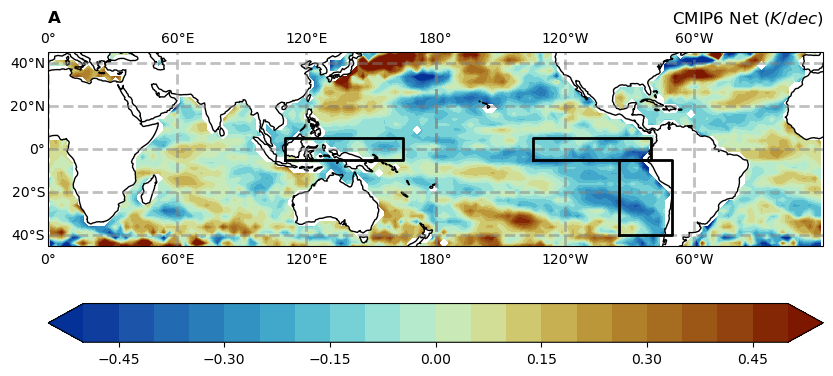

In [15]:
global_plot(
    data=SEB_CMIP6["NET"].sel(model="HadGEM3-GC31-MM").isel(time=1), 
    lat=SEB_CMIP6["NET"].lat,
    lon=SEB_CMIP6["NET"].lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="A", 
    right_title="CMIP6 Net $(K/dec)$"
)

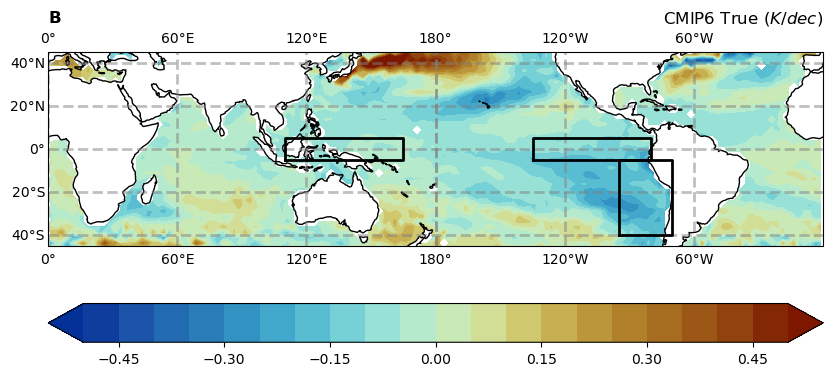

In [16]:
global_plot(
    data=SEB_CMIP6["TOS"].sel(model="HadGEM3-GC31-MM").isel(time=1), 
    lat=SEB_CMIP6["TOS"].lat,
    lon=SEB_CMIP6["TOS"].lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="B", 
    right_title="CMIP6 True $(K/dec)$"
)

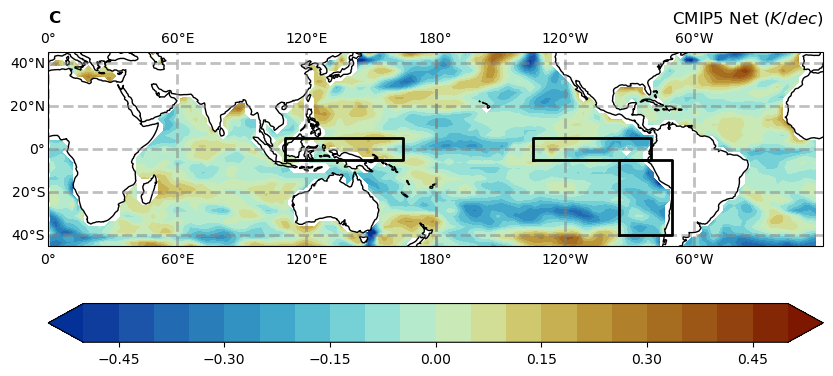

In [17]:
global_plot(
    data=SEB_CMIP5["NET"].sel(model="CNRM-CM5").isel(time=1), 
    lat=SEB_CMIP5["NET"].lat,
    lon=SEB_CMIP5["NET"].lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="C", 
    right_title="CMIP5 Net $(K/dec)$"
)

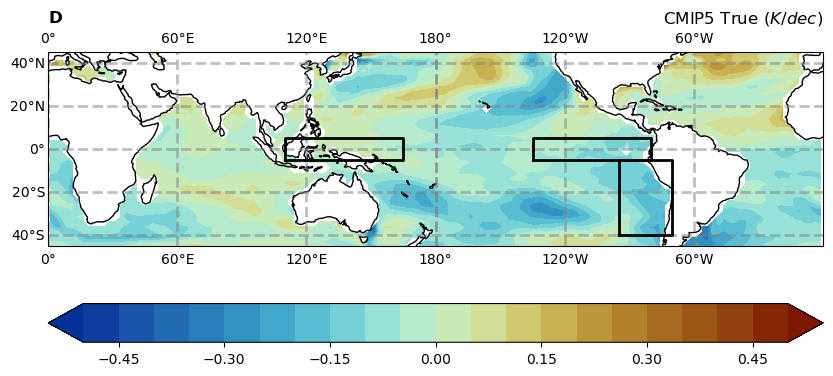

In [18]:
global_plot(
    data=SEB_CMIP5["TOS"].sel(model="CNRM-CM5").isel(time=1), 
    lat=SEB_CMIP5["TOS"].lat,
    lon=SEB_CMIP5["TOS"].lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="D", 
    right_title="CMIP5 True $(K/dec)$"
)

# SEB Composites

In [39]:
# Load Rolling Gradient for Regions TOS
SST_T_EPSA_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificSA_trend.nc").sel(model=shared_models_cmip6)
SST_T_WE_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_WE-Trend.nc").sel(model=shared_models_cmip6)
SST_T_E_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacific_trend.nc").sel(model=shared_models_cmip6)
SST_T_SO_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc").sel(model=shared_models_cmip6)

# Load Rolling Gradient for Regions TOS
SST_T_EPSA_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificSA_trend.nc").sel(model=shared_models_cmip5)
SST_T_WE_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_WE-Trend.nc").sel(model=shared_models_cmip5)
SST_T_E_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacific_trend.nc").sel(model=shared_models_cmip5)
SST_T_SO_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_southernOcean_trend.nc").sel(model=shared_models_cmip5)

In [64]:
def get_regional_means(flux, name="NET"):
    # WE
    flux_west = flux.sel(lat=slice(-5, 5), lon=slice(110, 165)).spatial.average(name)[name]
    flux_east = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
    flux_WE = (flux_west - flux_east)
    # EPSA
    flux_EPSA = flux.sel(lat=slice(-40, -5), lon=slice(-95, -70)).spatial.average(name)[name]
    # SO
    flux_SO = flux.sel(lat=slice(-70, -50), lon=slice(-180, -75)).spatial.average(name)[name]
    # EP
    flux_EP = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]

    return {"WE": flux_WE, "EPSA": flux_EPSA, "SO": flux_SO, "EP": flux_EP}

def remove_land_full(ds, var="skt"):
    ds = ds.rename(var).to_dataset()
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.lon, ds.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],ds[var].shape[1], 1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land


def composite_sigma_anoms(X, Y, var_name, region="EPSA", remove_land=True):
    dsX, dsY, dsY_region_mean, dsY_region_var = [], [], [], []

    Y_ocean = remove_land_full(ds=Y[var_name], var=var_name)
    Y_region = get_regional_means(Y, name=var_name)[region]

    for model in X.model:
        cX = X.sel(model=model)
        cY = Y_ocean.sel(model=model)
        cY_region = Y_region.sel(model=model)

        idxMax = cX > (cX.mean("time") + cX.std("time"))

        cX_max = cX[idxMax].mean("time")
        cY_max = cY[idxMax, :, :].mean("time")
        cY_region_mean = cY_region[idxMax].mean("time")
        cY_region_var = cY_region[idxMax].std("time")
        

        dsX.append(cX_max)
        dsY.append(cY_max)
        dsY_region_mean.append(cY_region_mean)
        dsY_region_var.append(cY_region_var)

    # convert to DataArray
    dsX = xr.concat(dsX, dim="model")
    dsY = xr.concat(dsY, dim="model")
    dsY_region_mean = xr.concat(dsY_region_mean, dim="model")
    dsY_region_var = xr.concat(dsY_region_var, dim="model")


    return dsX, dsY, dsY_region_mean, dsY_region_var

# Regional Bar Plots of SEB for 1 sig

In [135]:
var_names = ["TOS", "NET", "SH", "O", "SW", "LW", "LWC", "SWC", "LH_Other"]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

def get_regional_composites(SST_T, SEB, region):
    means = []
    for name in var_names:
        _, _, mean, _ = composite_sigma_anoms(X=SST_T, Y=SEB, var_name=name, region=region, remove_land=True)
        means.append(mean)
    means = xr.merge(means)
    return means

means_cmip6 = get_regional_composites(SST_T_WE_CMIP6, SEB_CMIP6, "WE")
means_cmip5 = get_regional_composites(SST_T_WE_CMIP5, SEB_CMIP5, "WE")


[ 0.13181768  0.31832727 -0.00062563  0.07824022  0.10174281 -0.05010522
 -0.20231207  0.10915298  0.18638251]


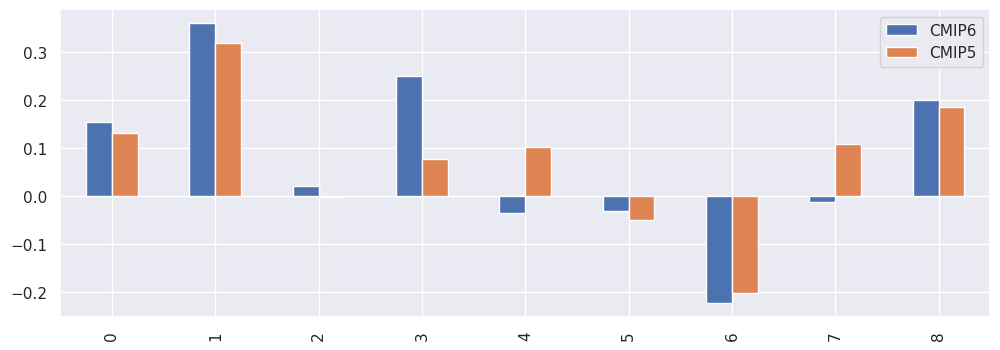

In [180]:
import pandas as pd


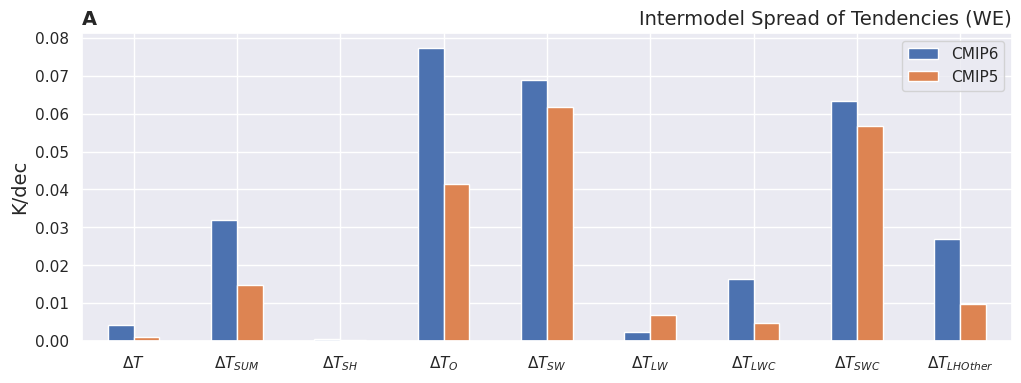

In [182]:
import seaborn as sns
var_names = ["TOS", "NET", "SH", "O", "SW", "LW", "LWC", "SWC", "LH_Other"]
ticklabels = [r"$\Delta T$", r"$\Delta T_{SUM}$", r"$\Delta T_{SH}$", r"$\Delta T_{O}$", r"$\Delta T_{SW}$", r"$\Delta T_{LW}$", r"$\Delta T_{LWC}$", r"$\Delta T_{SWC}$", r"$\Delta T_{LH Other}$"]


m6 = means_cmip6.var("model").to_pandas()
m5 = means_cmip5.var("model").to_pandas()
pd.DataFrame({'CMIP6': m6.values,'CMIP5': m5.values}).plot.bar()
plt.xticks(rotation=0)
# plt.ylabel(r"$(K/dec)^2$", fontsize=14)
plt.ylabel("K/dec", fontsize=14)
plt.xticks(ticks=np.arange(len(var_names)), labels=ticklabels)
plt.title("A", loc="left", fontweight="bold", fontsize=14)
plt.title("Intermodel Spread of Tendencies (WE)", loc="right", fontsize=14)
# plt.title("Average of Tendencies (WE)", loc="right", fontsize=14)
# Set size of figure
sns.set(rc={'figure.figsize':(12,4)})

## Spatial Plots of SEB for 1 sig

In [62]:
def plot_sigma_anoms(var_names, vars, SST_T, region="EPSA"):
    for i, (name, flux) in enumerate(zip(var_names, vars)):
        print(name)
        _, flux_sig, _, _ = composite_sigma_anoms(X=SST_T, Y=flux)
        
        # Plot Individual SEB 
        global_plot(
            data=flux_sig.mean("model"),
            lat=flux_sig.lat,
            lon=flux_sig.lon,
            pvalues=None, 
            levels=np.arange(-.26, .28, .02),
            # levels=np.arange(0, .32, .02),
            cmap=cmc.roma_r, 
            # cmap=cmc.batlowW, 
            left_title=labels[i], 
            right_title=f"{name} $(K/dec)$"
        )
        plt.savefig(f"figures/seb/mean_{name}_{region}.png")
        plt.show()

var_names = ["TOS", "NET", "SH", "O", "SW", "LW", "LWC", "SWC", r"LH$_{others}$", r"LH$_w$", r"LH$_{\Delta T}$", r"LH$_{RH}$"]
vars = [TOS_T, NET, -SH_T, O_T, SW_T, LW_T, LWC_T, SWC_T, -(LH_TW + LH_TDT + LH_TRH),-LH_TW, -LH_TDT, -LH_TRH]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

plot_sigma_anoms(var_names, vars, SST_T_EPSA, region="EPSA")


TOS
<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144)
Coordinates:
    model    <U13 'MPI-ESM1-2-LR'
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    filler   (lat, lon) float64 0.0 0.0 0.0 ... -1.048e-05 -9.752e-06 -8.948e-06


ValueError: Cannot generate bounds for coordinate variable 'model' which has a length <= 1 (singleton).

# SEB Variance Analysis

TOS
<xarray.DataArray 'TOS' (model: 17)>
array([0.07694819, 0.0578956 , 0.05356221, 0.07387245, 0.06669533,
       0.06712328, 0.04631723, 0.08283063, 0.07913153, 0.06866054,
       0.10253956, 0.09041879, 0.05362818, 0.09571725, 0.08935762,
       0.09184298, 0.07519084])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


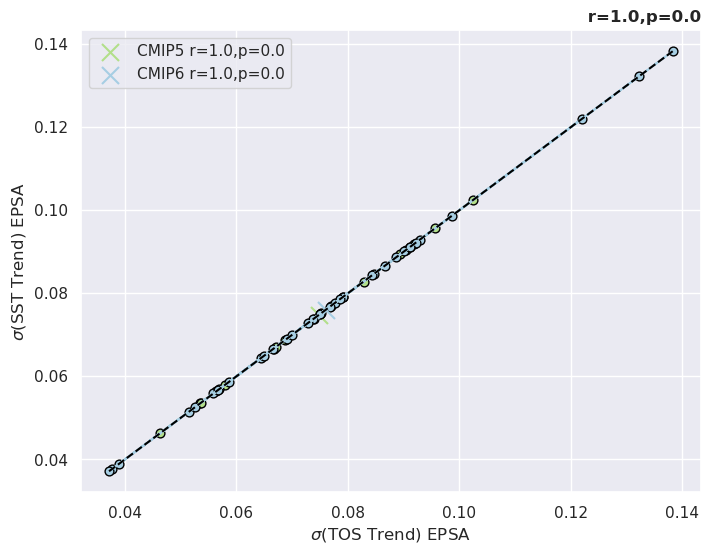

NET
<xarray.DataArray 'NET' (model: 17)>
array([0.06678565, 0.0579735 , 0.06593304, 0.07328217, 0.05755602,
       0.07269674, 0.04487609, 0.08008959, 0.07206599, 0.06816497,
       0.11107694, 0.07600791, 0.05606835, 0.07607715, 0.07970362,
       0.106901  , 0.06425323])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


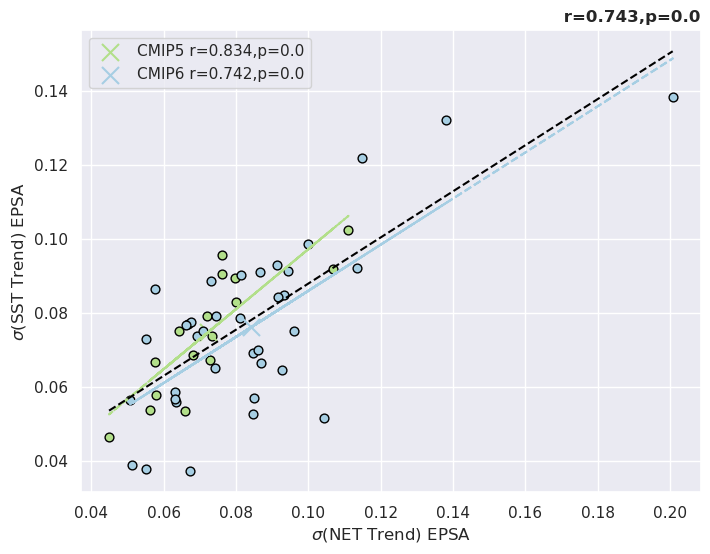

O
<xarray.DataArray 'O' (model: 17)>
array([0.06207278, 0.07948493, 0.08718563, 0.08734473, 0.064138  ,
       0.05900589, 0.04551641, 0.06352447, 0.07976305, 0.04662499,
       0.08439141, 0.04677614, 0.08215523, 0.09417234, 0.05676508,
       0.08345839, 0.05189346])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


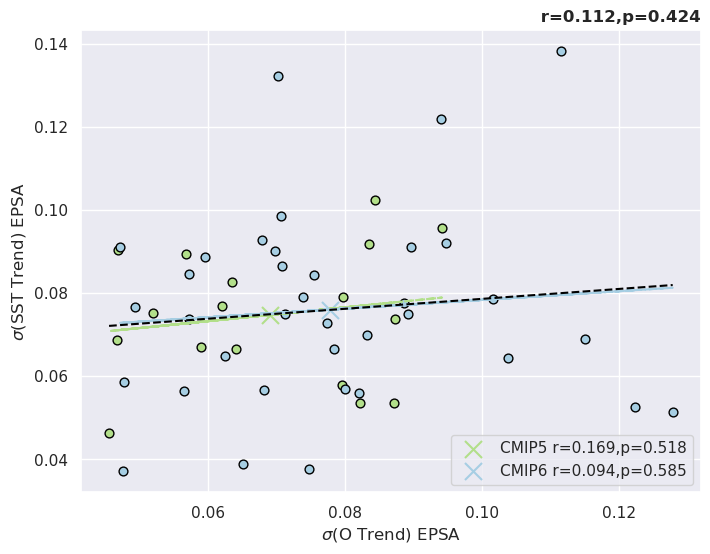

SW
<xarray.DataArray 'SW' (model: 17)>
array([0.04153915, 0.04699011, 0.06216417, 0.04877274, 0.0486428 ,
       0.04609867, 0.04901777, 0.04586121, 0.04165301, 0.04745211,
       0.08043896, 0.06626768, 0.03971581, 0.03824574, 0.06867575,
       0.07702168, 0.04713531])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


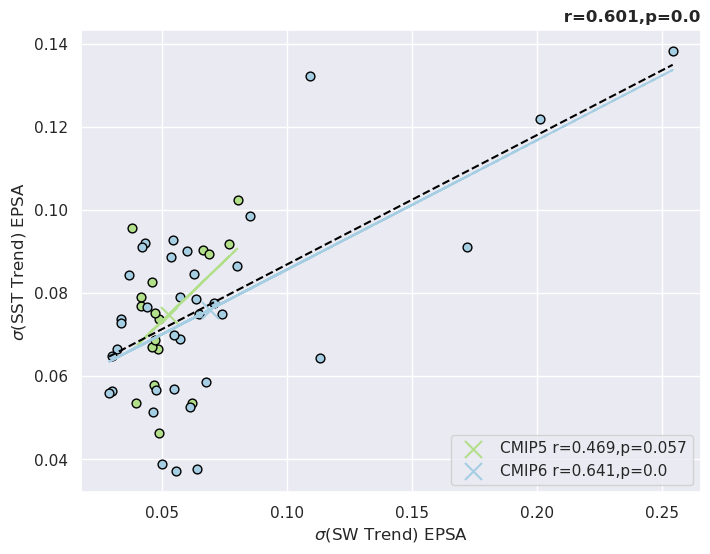

SWC
<xarray.DataArray 'SWC' (model: 17)>
array([0.04975186, 0.04012982, 0.0547747 , 0.05599204, 0.05069774,
       0.04653971, 0.04290704, 0.04412615, 0.04501792, 0.05424582,
       0.09038652, 0.06169333, 0.03581932, 0.02938915, 0.08282765,
       0.09064329, 0.05112365])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


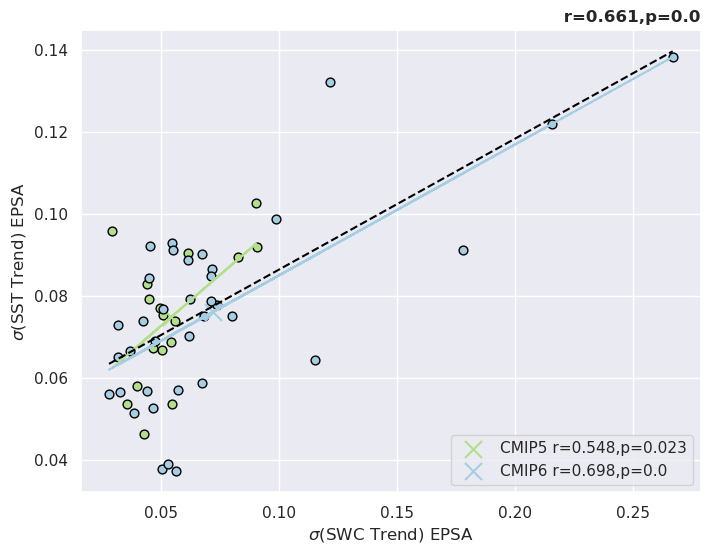

LW
<xarray.DataArray 'LW' (model: 17)>
array([0.03528055, 0.02623219, 0.02645007, 0.02522119, 0.02534365,
       0.03443651, 0.02651315, 0.02777976, 0.01853315, 0.03799301,
       0.04470787, 0.03780435, 0.02151695, 0.02948902, 0.0277456 ,
       0.03493696, 0.02510787])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


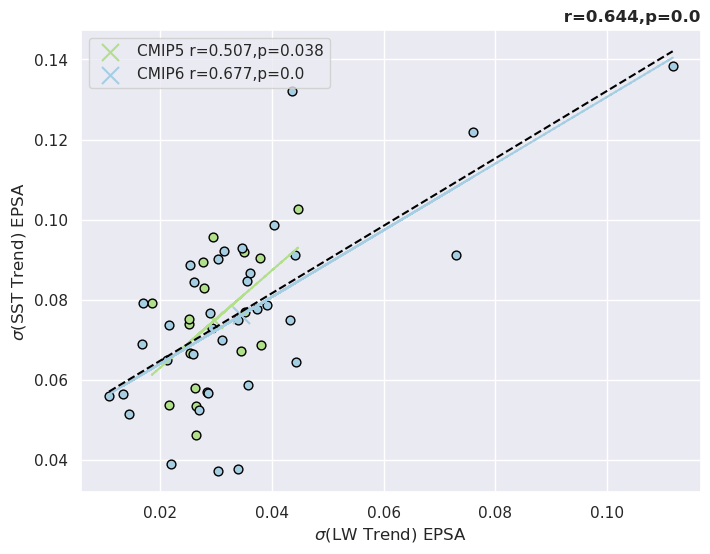

LWC
<xarray.DataArray 'LWC' (model: 17)>
array([0.1232742 , 0.05078145, 0.04978545, 0.09796408, 0.08671447,
       0.1024266 , 0.04029716, 0.09516667, 0.09062687, 0.11857535,
       0.14411984, 0.1049504 , 0.051102  , 0.0815917 , 0.13589537,
       0.12592126, 0.09944323])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


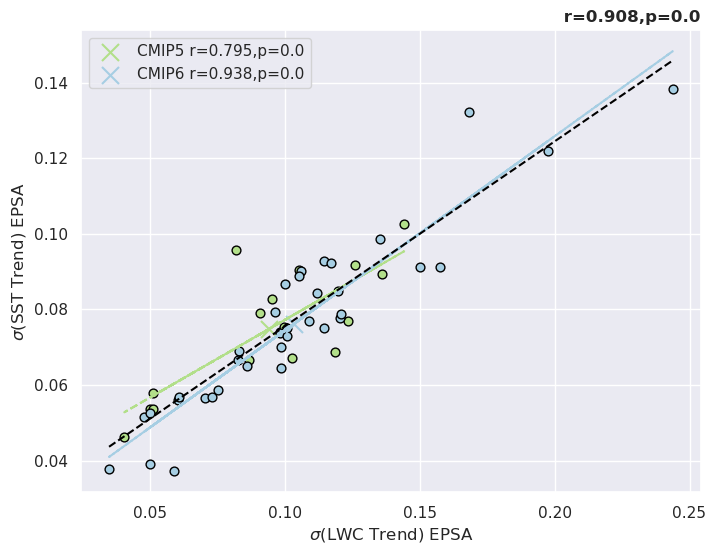

SH
<xarray.DataArray 'SH' (model: 17)>
array([0.02349159, 0.02462368, 0.01597856, 0.01737568, 0.01632775,
       0.03175476, 0.01319461, 0.01399901, 0.02158133, 0.01937946,
       0.01640912, 0.02224787, 0.01270798, 0.01852539, 0.0220999 ,
       0.01390581, 0.021042  ])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


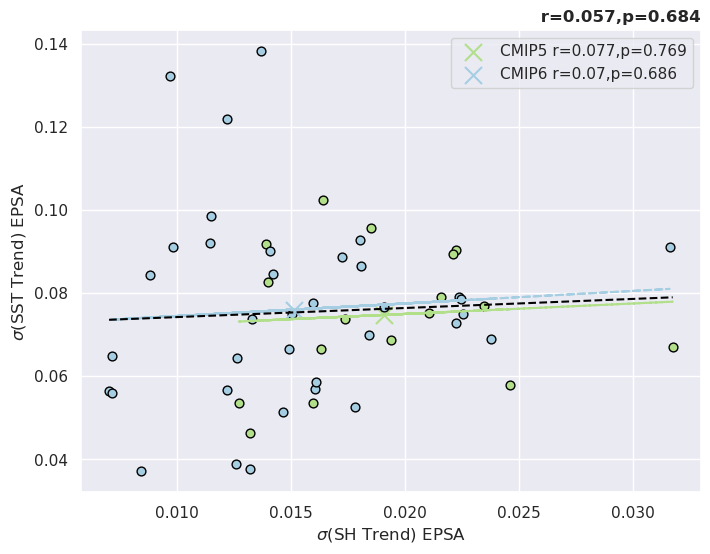

LH_Other
<xarray.DataArray 'LH_Other' (model: 17)>
array([0.03822069, 0.05653876, 0.05916861, 0.04288049, 0.04914746,
       0.04431675, 0.04105921, 0.05516583, 0.05043235, 0.0600567 ,
       0.05097486, 0.05339812, 0.04161304, 0.06136076, 0.03797867,
       0.07244719, 0.05252339])
Coordinates:
  * model    (model) object 'IPSL-CM5A-MR' 'GISS-E2-H-CC' ... 'ACCESS1-3'
['IPSL-CM5A-MR' 'GISS-E2-H-CC' 'GISS-E2-H' 'MPI-ESM-LR' 'MIROC-ESM'
 'IPSL-CM5A-LR' 'GISS-E2-R-CC' 'GFDL-CM3' 'MPI-ESM-MR' 'IPSL-CM5B-LR'
 'ACCESS1-0' 'MIROC-ESM-CHEM' 'CNRM-CM5' 'CNRM-CM5-2' 'CSIRO-Mk3-6-0'
 'HadGEM2-CC' 'ACCESS1-3']


/tmp/ipykernel_215001/1666079509.py:54: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
/tmp/ipykernel_215001/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


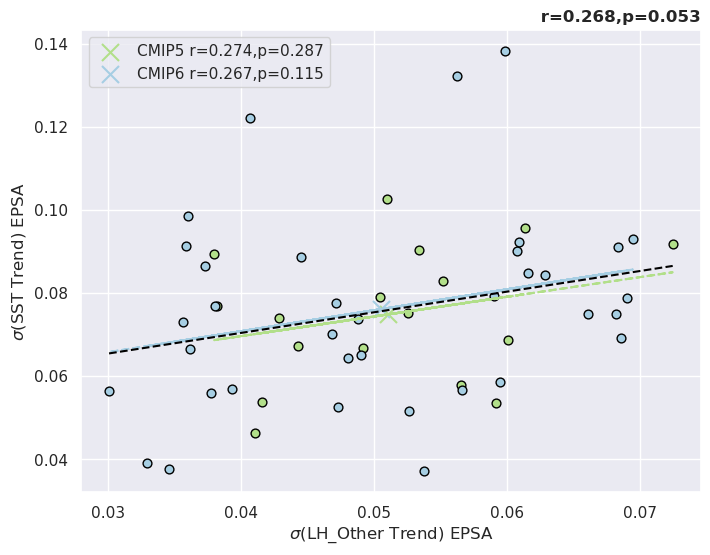

In [145]:
def get_region(name, flux, flux_region): 
    if flux_region == "WE":
        flux_west = flux.sel(lat=slice(-5, 5), lon=slice(110, 165)).spatial.average(name)[name]
        flux_east = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
        flux = (flux_west - flux_east).std("time")
        # flux_mean[name] = (flux_west - flux_east).mean("time", skipna=True)
    elif flux_region == "EPSA":
        flux = flux.sel(lat=slice(-40, -5), lon=slice(-95, -70)).spatial.average(name)[name]
        # flux_mean[name] = flux.mean("time", skipna=True)
        flux = flux.std("time")
    elif flux_region == "SO":
        flux = flux.sel(lat=slice(-70, -50), lon=slice(-180, -75)).spatial.average(name)[name]
        # flux_mean[name] = flux.mean("time", skipna=True)
        flux = flux.std("time")
    elif flux_region == "EP":
        flux = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
        # flux_mean[name] = flux.mean("time", skipna=True)
        flux = flux.std("time")
    else: 
        raise ValueError("Invalid flux region")

    return flux


def scatter_plot_seb(
    var_names, 
    seb_cmip6,
    seb_cmip5, 
    sst_t_cmip6, 
    sst_t_cmip5, 
    SST_region="WE", 
    flux_region="WE", 
    scatter=True
):
    sns.set(rc={'figure.figsize':(8,6)})
    for i, name in enumerate(var_names):
        plt.grid()
        print(name)
        flux6 = get_region(name, seb_cmip6, flux_region)
        flux5 = get_region(name, seb_cmip5, flux_region)

        # Plot Individual SEB 
        if scatter:
            print(flux5)
            print(seb_cmip5.model.values)
            create_scatter(
                x6=flux6, 
                y6=(sst_t_cmip6).std("time"), 
                x5=flux5, 
                y5=(sst_t_cmip5).std("time"), 
                vline=[],
                xlabel=f"$\sigma$({name} Trend) {flux_region}", 
                ylabel=f"$\sigma$(SST Trend) {SST_region}",
            )

            plt.savefig(f"figures/seb/{name}_scatter_flux{flux_region}_sst{SST_region}_test.png")
            plt.show()

var_names = ["TOS", "NET", "O", "SW", "SWC", "LW", "LWC", "SH", "LH_Other"] 
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

scatter_plot_seb(var_names, SEB_CMIP6, SEB_CMIP5, SST_T_EPSA_CMIP6/3, SST_T_EPSA_CMIP5/3, SST_region="EPSA", flux_region="EPSA", scatter=True)

In [33]:
import seaborn as sns

def violin_plot_tos(tos, title):
    fig = plt.figure()
    sns.set_palette("husl")
    sns.violinplot(data=tos, inner="box", width=8)
    # plt.title(title + r" SST$_{EPSA}$ Trend ($K/Dec$)")
    plt.grid()
    plt.xticks(fontsize=15)
    # Rotate the y-axis labels
    plt.tick_params(axis='x')
    fig.set_size_inches(15, 5)
    plt.xlabel("")
    plt.title(r"SST$_{WE}$ Trend ($K/Dec$)", fontsize=15, loc="right", weight="bold")

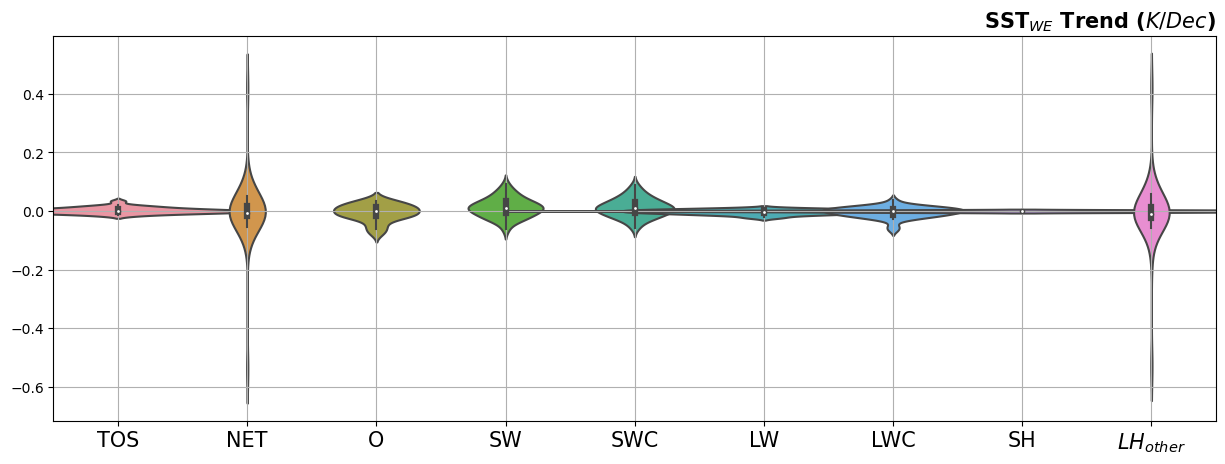

In [34]:
import pandas as pd

violin_plot_tos(pd.DataFrame(flux_mean), title="CMIP6")